In [25]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder 
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, SGDRegressor, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, BaggingRegressor, ExtraTreesRegressor
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [26]:
#Reading the train data
df = pd.read_csv("train.csv")
y = df['SalePrice']

In [27]:
#Removal of Outliers
removed = 0
thresh = 500000
for i in df.index:
    if y[i]>thresh:
        df = df.drop(i)
        removed+=1
print('Data points removed: '+str(removed))

Data points removed: 9


In [28]:
#Separating features and target variable
X = df.drop(['Id', 'SalePrice'], axis=1)
y = df['SalePrice']
df.shape

(1451, 81)

In [29]:
#Separating numerical and categorical features
numeric_X = X[X.dtypes[X.dtypes != "object"].index]
categorical_X = X[X.dtypes[X.dtypes == "object"].index]
numeric_X.head()

MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0          60         65.0     8450            7            5       2003   
1          20         80.0     9600            6            8       1976   
2          60         68.0    11250            7            5       2001   
3          70         60.0     9550            7            5       1915   
4          60         84.0    14260            8            5       2000   

   YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  ...  GarageArea  \
0          2003       196.0         706           0  ...         548   
1          1976         0.0         978           0  ...         460   
2          2002       162.0         486           0  ...         608   
3          1970         0.0         216           0  ...         642   
4          2000       350.0         655           0  ...         836   

   WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea  \
0           0           61              0          0            0         0   
1         298            0              0          0            0         0   
2           0           42              0          0            0         0   
3           0           35            272          0            0         0   
4         192           84              0          0            0         0   

   MiscVal  MoSold  YrSold  
0        0       2    2008  
1        0       5    2007  
2        0       9    2008  
3        0       2    2006  
4        0      12    2008  

[5 rows x 36 columns]

In [30]:
#Calculating the distribution of missing values for numerical features
parameter_na=[i for i in numeric_X.columns if numeric_X[i].isnull().sum()>1]

for i in parameter_na:
    print(i, np.round(numeric_X[i].isnull().mean(),2),' % missing values')

LotFrontage 0.18  % missing values
MasVnrArea 0.01  % missing values
GarageYrBlt 0.06  % missing values


In [31]:
#Calculating the distribution of misssing values for categorical features
#First removing features with "NA" as a parameter
categorical_X1 = categorical_X.drop(['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature'
], axis=1)

parameter_na=[i for i in categorical_X1.columns if categorical_X1[i].isnull().sum()>1]

for i in parameter_na:
    print(i, np.round(categorical_X1[i].isnull().mean(),2),' % missing values')

MasVnrType 0.01  % missing values


In [32]:
#Removing the categorical feature with missing value
categorical_X = categorical_X.drop(['MasVnrType'], axis=1)

In [33]:
#Imputing the missing values(Replacing NA with a suitable metric of the feature elements)
numeric_X = numeric_X.replace(np.nan,numeric_X['LotFrontage'].median())
numeric_X = numeric_X.replace(np.nan,numeric_X['MasVnrArea'].median())
numeric_X = numeric_X.replace(np.nan,numeric_X['GarageYrBlt'].mean())

In [34]:
#Verifying that the missing values are replaced
k=0
for feat in numeric_X.columns:
    if(numeric_X[feat].isnull().sum()>1):
        k=k+1
if(k!=0):
    print("Missing values present")
else:
    print("No Missing Values")


No Missing Values


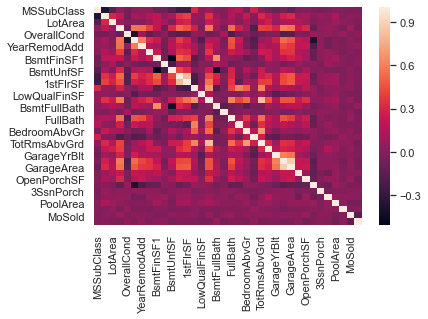

False
1stFlrSF
False
TotRmsAbvGrd
False
GarageArea
(1451, 33)


In [35]:
#Finding correlation between numerical features
corr = numeric_X.corr()

#Plotting the heat map
sns.heatmap(corr)
plt.show()

#Eliminating columns with high correlation (>0.8)
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.8:
            if columns[j]:
                columns[j] = False
                print(columns[j])
                print(numeric_X.columns[j])
selected_columns = numeric_X.columns[columns]
new_features = numeric_X[selected_columns].values
print(new_features.shape)

In [36]:
#Dropping the features having high correlation
numeric_X = numeric_X.drop(['1stFlrSF', 'TotRmsAbvGrd', 'GarageArea'], axis=1)

In [37]:
#Replacing the "NA" value to a string to avoid any errors
for i in categorical_X:
    categorical_X = categorical_X.replace(np.nan,'NA')

In [38]:
#Encoding categorical features
#First encoding unordered features using one-hot encoding
unordered = ['MSZoning','LotShape','LandContour', 'LotConfig',
                         'Neighborhood','Condition1', 'Condition2', 'BldgType',
                         'HouseStyle','RoofStyle','RoofMatl','Exterior1st','Exterior2nd',
                         'Foundation','Heating','GarageType','SaleType',
                         'SaleCondition','MiscFeature']
unordered = df[unordered]
unordered = pd.get_dummies(unordered)

In [39]:
#Encoding ordered features using label encoding
ordered = ['Street','Alley','Utilities','LandSlope',
                      'ExterQual', 'ExterCond','BsmtQual','BsmtCond',
                       'BsmtExposure','BsmtFinType1','BsmtFinType2','HeatingQC',
                       'CentralAir','Electrical','KitchenQual','Functional',
                       'FireplaceQu','GarageFinish', 'GarageQual',
                       'GarageCond', 'PavedDrive','PoolQC','Fence']

# instantiate labelencoder object
le = LabelEncoder()
# apply le on categorical feature columns
for f in ordered:
    categorical_X[f] = le.fit_transform(categorical_X[f])
categorical_X.describe()

Street        Alley    Utilities    LandSlope    ExterQual  \
count  1451.000000  1451.000000  1451.000000  1451.000000  1451.000000   
mean      0.995865     0.993797     0.000689     0.062026     2.551344   
std       0.064194     0.250440     0.026252     0.275953     0.676158   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       1.000000     1.000000     0.000000     0.000000     2.000000   
50%       1.000000     1.000000     0.000000     0.000000     3.000000   
75%       1.000000     1.000000     0.000000     0.000000     3.000000   
max       1.000000     2.000000     1.000000     2.000000     3.000000   

         ExterCond     BsmtQual     BsmtCond  BsmtExposure  BsmtFinType1  ...  \
count  1451.000000  1451.000000  1451.000000   1451.000000   1451.000000  ...   
mean      3.733287     2.740179     3.689180      2.948312      3.155755  ...   
std       0.732394     1.266286     0.952246      1.563622      2.254314  ...   
min       0.000000     0.000000     0.000000      0.000000      0.000000  ...   
25%       4.000000     2.000000     4.000000      2.000000      1.000000  ...   
50%       4.000000     2.000000     4.000000      4.000000      2.000000  ...   
75%       4.000000     4.000000     4.000000      4.000000      6.000000  ...   
max       4.000000     4.000000     4.000000      4.000000      6.000000  ...   

        Electrical  KitchenQual   Functional  FireplaceQu  GarageFinish  \
count  1451.000000  1451.000000  1451.000000  1451.000000   1451.000000   
mean      4.593384     2.352860     5.749139     3.091661      1.886975   
std       1.332381     0.814242     0.981444     1.164062      1.187133   
min       0.000000     0.000000     0.000000     0.000000      0.000000   
25%       5.000000     2.000000     6.000000     2.000000      1.000000   
50%       5.000000     3.000000     6.000000     3.000000      2.000000   
75%       5.000000     3.000000     6.000000     3.000000      3.000000   
max       5.000000     3.000000     6.000000     5.000000      3.000000   

        GarageQual   GarageCond   PavedDrive       PoolQC        Fence  
count  1451.000000  1451.000000  1451.000000  1451.000000  1451.000000  
mean      4.714680     4.761544     1.855272     2.993108     3.503101  
std       0.901293     0.804939     0.498001     0.117242     1.084924  
min       0.000000     0.000000     0.000000     0.000000     0.000000  
25%       5.000000     5.000000     2.000000     3.000000     4.000000  
50%       5.000000     5.000000     2.000000     3.000000     4.000000  
75%       5.000000     5.000000     2.000000     3.000000     4.000000  
max       5.000000     5.000000     2.000000     3.000000     4.000000  

[8 rows x 23 columns]

In [40]:
#Combining the two types of categorical features
cat_X = pd.concat([categorical_X,unordered], axis=1)
cat_X.describe()

Street        Alley    Utilities    LandSlope    ExterQual  \
count  1451.000000  1451.000000  1451.000000  1451.000000  1451.000000   
mean      0.995865     0.993797     0.000689     0.062026     2.551344   
std       0.064194     0.250440     0.026252     0.275953     0.676158   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       1.000000     1.000000     0.000000     0.000000     2.000000   
50%       1.000000     1.000000     0.000000     0.000000     3.000000   
75%       1.000000     1.000000     0.000000     0.000000     3.000000   
max       1.000000     2.000000     1.000000     2.000000     3.000000   

         ExterCond     BsmtQual     BsmtCond  BsmtExposure  BsmtFinType1  ...  \
count  1451.000000  1451.000000  1451.000000   1451.000000   1451.000000  ...   
mean      3.733287     2.740179     3.689180      2.948312      3.155755  ...   
std       0.732394     1.266286     0.952246      1.563622      2.254314  ...   
min       0.000000     0.000000     0.000000      0.000000      0.000000  ...   
25%       4.000000     2.000000     4.000000      2.000000      1.000000  ...   
50%       4.000000     2.000000     4.000000      4.000000      2.000000  ...   
75%       4.000000     4.000000     4.000000      4.000000      6.000000  ...   
max       4.000000     4.000000     4.000000      4.000000      6.000000  ...   

       SaleCondition_Abnorml  SaleCondition_AdjLand  SaleCondition_Alloca  \
count            1451.000000            1451.000000           1451.000000   
mean                0.068918               0.002757              0.008270   
std                 0.253402               0.052450              0.090595   
min                 0.000000               0.000000              0.000000   
25%                 0.000000               0.000000              0.000000   
50%                 0.000000               0.000000              0.000000   
75%                 0.000000               0.000000              0.000000   
max                 1.000000               1.000000              1.000000   

       SaleCondition_Family  SaleCondition_Normal  SaleCondition_Partial  \
count           1451.000000           1451.000000            1451.000000   
mean               0.013784              0.822881               0.083391   
std                0.116632              0.381901               0.276567   
min                0.000000              0.000000               0.000000   
25%                0.000000              1.000000               0.000000   
50%                0.000000              1.000000               0.000000   
75%                0.000000              1.000000               0.000000   
max                1.000000              1.000000               1.000000   

       MiscFeature_Gar2  MiscFeature_Othr  MiscFeature_Shed  MiscFeature_TenC  
count       1451.000000       1451.000000       1451.000000       1451.000000  
mean           0.001378          0.001378          0.033770          0.000689  
std            0.037113          0.037113          0.180698          0.026252  
min            0.000000          0.000000          0.000000          0.000000  
25%            0.000000          0.000000          0.000000          0.000000  
50%            0.000000          0.000000          0.000000          0.000000  
75%            0.000000          0.000000          0.000000          0.000000  
max            1.000000          1.000000          1.000000          1.000000  

[8 rows x 178 columns]

In [41]:
#Making a Dataset
X_train = pd.concat([numeric_X, cat_X], axis=1)
X_train.describe()

MSSubClass  LotFrontage        LotArea  OverallQual  OverallCond  \
count  1451.000000  1451.000000    1451.000000  1451.000000  1451.000000   
mean     56.960717    69.684356   10442.747760     6.079256     5.578222   
std      42.397924    21.845215    9916.673175     1.362524     1.115370   
min      20.000000    21.000000    1300.000000     1.000000     1.000000   
25%      20.000000    60.000000    7517.500000     5.000000     5.000000   
50%      50.000000    69.000000    9452.000000     6.000000     5.000000   
75%      70.000000    78.500000   11506.000000     7.000000     6.000000   
max     190.000000   313.000000  215245.000000    10.000000     9.000000   

         YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1   BsmtFinSF2  ...  \
count  1451.000000   1451.000000  1451.000000  1451.000000  1451.000000  ...   
mean   1971.071675   1984.749828   100.352860   437.809097    46.466575  ...   
std      30.189728     20.651395   173.354099   447.757832   161.264463  ...   
min    1872.000000   1950.000000     0.000000     0.000000     0.000000  ...   
25%    1954.000000   1966.000000     0.000000     0.000000     0.000000  ...   
50%    1972.000000   1993.000000     0.000000   381.000000     0.000000  ...   
75%    2000.000000   2004.000000   160.500000   705.500000     0.000000  ...   
max    2010.000000   2010.000000  1600.000000  5644.000000  1474.000000  ...   

       SaleCondition_Abnorml  SaleCondition_AdjLand  SaleCondition_Alloca  \
count            1451.000000            1451.000000           1451.000000   
mean                0.068918               0.002757              0.008270   
std                 0.253402               0.052450              0.090595   
min                 0.000000               0.000000              0.000000   
25%                 0.000000               0.000000              0.000000   
50%                 0.000000               0.000000              0.000000   
75%                 0.000000               0.000000              0.000000   
max                 1.000000               1.000000              1.000000   

       SaleCondition_Family  SaleCondition_Normal  SaleCondition_Partial  \
count           1451.000000           1451.000000            1451.000000   
mean               0.013784              0.822881               0.083391   
std                0.116632              0.381901               0.276567   
min                0.000000              0.000000               0.000000   
25%                0.000000              1.000000               0.000000   
50%                0.000000              1.000000               0.000000   
75%                0.000000              1.000000               0.000000   
max                1.000000              1.000000               1.000000   

       MiscFeature_Gar2  MiscFeature_Othr  MiscFeature_Shed  MiscFeature_TenC  
count       1451.000000       1451.000000       1451.000000       1451.000000  
mean           0.001378          0.001378          0.033770          0.000689  
std            0.037113          0.037113          0.180698          0.026252  
min            0.000000          0.000000          0.000000          0.000000  
25%            0.000000          0.000000          0.000000          0.000000  
50%            0.000000          0.000000          0.000000          0.000000  
75%            0.000000          0.000000          0.000000          0.000000  
max            1.000000          1.000000          1.000000          1.000000  

[8 rows x 211 columns]

In [42]:
#Finding the correlation between target variable and features
temp_data = pd.concat([X_train,df['SalePrice']],axis=1)
corr = temp_data.corr()
useful_feat = []
for i in corr.columns:
    if (corr[i]['SalePrice'])>=.1 or (corr[i]['SalePrice'])<=-.1:
        useful_feat.append(i)
        
X_t = temp_data[useful_feat]
X_t = X_t.drop(['SalePrice'], axis=1)
X_t.describe()

LotFrontage        LotArea  OverallQual    YearBuilt  YearRemodAdd  \
count  1451.000000    1451.000000  1451.000000  1451.000000   1451.000000   
mean     69.684356   10442.747760     6.079256  1971.071675   1984.749828   
std      21.845215    9916.673175     1.362524    30.189728     20.651395   
min      21.000000    1300.000000     1.000000  1872.000000   1950.000000   
25%      60.000000    7517.500000     5.000000  1954.000000   1966.000000   
50%      69.000000    9452.000000     6.000000  1972.000000   1993.000000   
75%      78.500000   11506.000000     7.000000  2000.000000   2004.000000   
max     313.000000  215245.000000    10.000000  2010.000000   2010.000000   

        MasVnrArea   BsmtFinSF1    BsmtUnfSF  TotalBsmtSF     2ndFlrSF  ...  \
count  1451.000000  1451.000000  1451.000000  1451.000000  1451.000000  ...   
mean    100.352860   437.809097   566.076499  1050.352171   342.745003  ...   
std     173.354099   447.757832   440.565397   429.484478   429.825177  ...   
min       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
25%       0.000000     0.000000   222.000000   794.500000     0.000000  ...   
50%       0.000000   381.000000   476.000000   990.000000     0.000000  ...   
75%     160.500000   705.500000   808.000000  1285.000000   728.000000  ...   
max    1600.000000  5644.000000  2336.000000  6110.000000  1818.000000  ...   

       Foundation_PConc  Foundation_Slab  GarageType_Attchd  \
count       1451.000000      1451.000000        1451.000000   
mean           0.439697         0.016540           0.595451   
std            0.496521         0.127585           0.490974   
min            0.000000         0.000000           0.000000   
25%            0.000000         0.000000           0.000000   
50%            0.000000         0.000000           1.000000   
75%            1.000000         0.000000           1.000000   
max            1.000000         1.000000           1.000000   

       GarageType_BuiltIn  GarageType_Detchd  SaleType_New  SaleType_WD  \
count         1451.000000        1451.000000   1451.000000  1451.000000   
mean             0.058580           0.266713      0.081323     0.869745   
std              0.234918           0.442393      0.273425     0.336700   
min              0.000000           0.000000      0.000000     0.000000   
25%              0.000000           0.000000      0.000000     1.000000   
50%              0.000000           0.000000      0.000000     1.000000   
75%              0.000000           1.000000      0.000000     1.000000   
max              1.000000           1.000000      1.000000     1.000000   

       SaleCondition_Abnorml  SaleCondition_Normal  SaleCondition_Partial  
count            1451.000000           1451.000000            1451.000000  
mean                0.068918              0.822881               0.083391  
std                 0.253402              0.381901               0.276567  
min                 0.000000              0.000000               0.000000  
25%                 0.000000              1.000000               0.000000  
50%                 0.000000              1.000000               0.000000  
75%                 0.000000              1.000000               0.000000  
max                 1.000000              1.000000               1.000000  

[8 rows x 94 columns]

In [43]:
#Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_t, y, test_size=0.15, random_state=42)

In [ ]:
test_acc = []

for epoch in np.arange(1,101,1):
    print(epoch)
    X_train,X_test,Y_train,Y_test = train_test_split(X_t,y,test_size=0.15)
    model1 = ExtraTreesRegressor(bootstrap= True,
 max_depth= None,
 max_features= 'auto',
 min_samples_leaf= 1,
 min_samples_split= 2,
 n_estimators= 442)
    model2 = GradientBoostingRegressor(learning_rate= 0.05, n_estimators= 750,max_depth= 2,min_samples_leaf= 1, min_samples_split=2,
                              max_features='sqrt',subsample=0.85)
    model3 = RandomForestRegressor(bootstrap= False,
 max_depth= None,
 max_features= 'sqrt',
 min_samples_leaf= 1,
 min_samples_split= 2,
 n_estimators= 385)
    model1.fit(X_train,Y_train)
    model2.fit(X_train,Y_train)
    model3.fit(X_train,Y_train)
    y_pred = model1.predict(X_test)*0.15 + model2.predict(X_test)*0.7 + model3.predict(X_test)*0.15
    score_test = r2_score(Y_test,y_pred)
    test_acc.append(round(score_test,3))
    print(round(score_test,3))
test_acc = np.sort(test_acc)
fig, ax = plt.subplots(figsize=(6,4))
test = [t*100 for t in test_acc]
k = np.arange(1,101,1)
ax.plot(k,test,marker='o',color='r') 
ax.set_title('Accuracy')
ax.set_ylabel('Accuracy')
ax.set_xlabel('k')
plt.grid()
fig.tight_layout()
mean_test = round(np.mean(test),1)
std = round(np.std(test),1)
print("Test Accuracy: "+str(mean_test)+"+/-"+str(std))
print(test)
plt.show()

In [44]:
#Reading the test file
df_test = pd.read_csv('test.csv')
df_test.shape

(1459, 80)

In [45]:
test_X = df_test.drop(['Id'], axis=1)
test_X.shape

(1459, 79)

In [46]:
numeric_X_test = test_X[test_X.dtypes[test_X.dtypes != "object"].index]
categorical_X_test = test_X[test_X.dtypes[test_X.dtypes == "object"].index]
numeric_X_test.shape

(1459, 36)

In [47]:
parameter_na=[i for i in numeric_X_test.columns if numeric_X_test[i].isnull().sum()>1]

for i in parameter_na:
    print(i, np.round(numeric_X_test[i].isnull().mean(),2),' % missing values')

LotFrontage 0.16  % missing values
MasVnrArea 0.01  % missing values
BsmtFullBath 0.0  % missing values
BsmtHalfBath 0.0  % missing values
GarageYrBlt 0.05  % missing values


In [48]:
#Imputing the missing values(Replacing NA with suitable metric of the feature elements)
numeric_X_test = numeric_X_test.replace(np.nan,numeric_X_test['LotFrontage'].median())
numeric_X_test = numeric_X_test.replace(np.nan,numeric_X_test['MasVnrArea'].median())
numeric_X_test = numeric_X_test.replace(np.nan,numeric_X_test['GarageYrBlt'].mean())
numeric_X_test = numeric_X_test.replace(np.nan,numeric_X_test['BsmtFullBath'].median())
numeric_X_test = numeric_X_test.replace(np.nan,numeric_X_test['BsmtHalfBath'].median())
numeric_X_test.shape

(1459, 36)

In [49]:
numeric_X_test = numeric_X_test.drop(['1stFlrSF', 'TotRmsAbvGrd', 'GarageArea'], axis=1)

In [50]:
#One hot encoding
unordered = ['MSZoning','LotShape','LandContour', 'LotConfig',
                         'Neighborhood','Condition1', 'Condition2', 'BldgType',
                         'HouseStyle','RoofStyle','RoofMatl','Exterior1st','Exterior2nd',
                         'Foundation','Heating','GarageType','SaleType',
                         'SaleCondition','MiscFeature']
unordered = df_test[unordered]
unordered = pd.get_dummies(unordered)

In [51]:
cat_X_test = test_X[test_X.dtypes[test_X.dtypes == "object"].index]
cat_X_test = cat_X_test.drop(['MasVnrType'],axis=1)
for f in cat_X_test.columns:
    cat_X_test[f] = cat_X_test[f].replace(np.nan,"NA")

# apply le on categorical feature columns
for f in ordered:
    cat_X_test[f] = le.fit_transform(cat_X_test[f])
cat_X_test.describe()
cat_X_test.shape

(1459, 42)

In [52]:
cat_X_test = pd.concat([cat_X_test, unordered], axis=1)

In [53]:
X_test1 = pd.concat([numeric_X_test, cat_X_test], axis=1)
X_test1.shape

(1459, 216)

In [55]:
useful_test = useful_feat
useful_test.pop(-1)

'SalePrice'

In [56]:
X_test2 = X_test1[useful_test]
X_test2.describe()

LotFrontage       LotArea  OverallQual    YearBuilt  YearRemodAdd  \
count  1459.000000   1459.000000  1459.000000  1459.000000   1459.000000   
mean     68.334476   9819.161069     6.078821  1971.357779   1983.662783   
std      20.569211   4955.517327     1.436812    30.390071     21.130467   
min      21.000000   1470.000000     1.000000  1879.000000   1950.000000   
25%      60.000000   7391.000000     5.000000  1953.000000   1963.000000   
50%      67.000000   9399.000000     6.000000  1973.000000   1992.000000   
75%      78.000000  11517.500000     7.000000  2001.000000   2004.000000   
max     200.000000  56600.000000    10.000000  2010.000000   2010.000000   

        MasVnrArea   BsmtFinSF1    BsmtUnfSF  TotalBsmtSF     2ndFlrSF  ...  \
count  1459.000000  1459.000000  1459.000000  1459.000000  1459.000000  ...   
mean    100.362577   438.948595   553.960932  1045.446881   325.967786  ...   
std     176.742559   455.216193   437.296637   443.488135   420.610226  ...   
min       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
25%       0.000000     0.000000   219.000000   784.000000     0.000000  ...   
50%       0.000000   350.000000   460.000000   988.000000     0.000000  ...   
75%     162.000000   752.000000   797.500000  1304.000000   676.000000  ...   
max    1290.000000  4010.000000  2140.000000  5095.000000  1862.000000  ...   

       Foundation_PConc  Foundation_Slab  GarageType_Attchd  \
count       1459.000000      1459.000000        1459.000000   
mean           0.453050         0.017135           0.584647   
std            0.497962         0.129819           0.492952   
min            0.000000         0.000000           0.000000   
25%            0.000000         0.000000           0.000000   
50%            0.000000         0.000000           1.000000   
75%            1.000000         0.000000           1.000000   
max            1.000000         1.000000           1.000000   

       GarageType_BuiltIn  GarageType_Detchd  SaleType_New  SaleType_WD  \
count         1459.000000        1459.000000   1459.000000  1459.000000   
mean             0.067169           0.268677      0.080192     0.862234   
std              0.250401           0.443424      0.271683     0.344772   
min              0.000000           0.000000      0.000000     0.000000   
25%              0.000000           0.000000      0.000000     1.000000   
50%              0.000000           0.000000      0.000000     1.000000   
75%              0.000000           1.000000      0.000000     1.000000   
max              1.000000           1.000000      1.000000     1.000000   

       SaleCondition_Abnorml  SaleCondition_Normal  SaleCondition_Partial  
count            1459.000000           1459.000000            1459.000000  
mean                0.061001              0.825223               0.082248  
std                 0.239414              0.379907               0.274837  
min                 0.000000              0.000000               0.000000  
25%                 0.000000              1.000000               0.000000  
50%                 0.000000              1.000000               0.000000  
75%                 0.000000              1.000000               0.000000  
max                 1.000000              1.000000               1.000000  

[8 rows x 94 columns]

In [57]:
y_pred = model1.predict(X_test2)*0.15 + model2.predict(X_test2)*0.7 + model3.predict(X_test2)*0.15
df_test['SalePrice'] = y_pred

NameError: name 'model1' is not defined

In [40]:
df_val = pd.read_csv('sample_submission.csv')
y_pred.shape

(1459,)

In [41]:
y_val = df_val['SalePrice']
y_val.shape

(1459,)

In [42]:
print(mean_absolute_error(y_pred,y_val))  

53046.9303015


In [43]:
df_out = df_test['Id']
df_out.shape

(1459,)

In [44]:
df_out = pd.concat([df_out, df_test['SalePrice']], axis=1)
df_out.shape

(1459, 2)

In [45]:
df_out.to_csv('submission.csv')